<img src="./media/Logo Element-01.jpg"><h1 align="center">Vector Representations of with Tensorflow</h1>

<img src="./media/Deep_Learning_Icons_R5_PNG.png">

<img src="./media/18mag-18ai-t_CA3-master675.jpg">

<h1 align="center">Jeff Dean's PIN is the last 4 digits of pi</h1>

<h1 align="center">When Jeff Dean designs software, he first codes the binary and then writes the source as documentation</h1>

<h1 align="center">When Jeff Dean says "Hello World", the world says "Hello Jeff"</h1>

<img src="./media/18mag-18ai-t_CA1-master675.jpg">

<h1 align="center">What are Tensors?</h1>

<img src="./media/tensors.jpeg">

In [ ]:
import numpy as np
x = np.array(5)
print(x) # scalar

In [ ]:
x = np.array([1,2,3,4])
print(x) # vector

In [ ]:
x = np.array([[5,10,15,30,25],
              [20,30,65,70,90],
              [7,80,95,20,30]])
print(x) # matrix

<h1 align="center">TensorFlow Computation Mechanics</h1>

<h2>TensorFlow programs are usually structured into:</h2>

<h2>a **construction phase**, that assembles a graph, and</h2>

<h2>an execution phase that uses a session to execute ops in the graph.</h2>

<img src="./media/tensors_flowing.gif">

<h1 align="center">Multi-threaded word2vec mini-batched skip-gram model</h1>

<h2 align="center">(Mikolov, et. al.) Efficient Estimation of Word Representations in Vector Space.</h2>
<h3 align="center">International Conference on Learning Representations 2013</h3>

<h2>The key ops used are:</h2>
* placeholder for feeding in tensors for each example.
* embedding_lookup for fetching rows from the embedding matrix.
* sigmoid_cross_entropy_with_logits to calculate the loss.
* GradientDescentOptimizer for optimizing the loss.
* skipgram custom op that does input processing.

In [1]:
import os
import sys
import threading
import time

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
import collections
import math
import random
import zipfile
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

In [4]:
filename = 'text8.zip'
#filename = 'war_and_peace.txt.zip'

In [5]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile('./input/' + filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

In [6]:
words = read_data(filename)
print('Data size', len(words))

Data size 17005207


<h1 align="center">Step 2: Build the dictionary and replace rare words with UNK token.</h1>

In [7]:
vocabulary_size = 50000

In [8]:
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [9]:
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # to reduce memory use.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


<h1 align="center">Step 3: Function to generate a training batch for the skip-gram model.</h1>

In [10]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

In [11]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


<h1 align="center">Step 4: Build and train a skip-gram model.</h1>

<img src="./media/word2vec-context-words.png">

<img src="./media/word2vec-skip-gram.png">

In [12]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

In [13]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [14]:
graph = tf.Graph()

In [15]:
with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

# Step 5: Begin training.

In [16]:
num_steps = 100001

In [17]:
with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  286.854431152
Nearest to only: budgeted, assimilate, earnings, exclaims, agathon, themselves, indemnity, either,
Nearest to world: iniquity, linda, halftime, characterises, antithetical, organelles, forcibly, fayetteville,
Nearest to its: ien, contralto, tropes, cs, baha, borden, apparel, nitrite,
Nearest to than: balance, currie, pear, imitative, tivoli, lobbying, nc, respondents,
Nearest to in: prussian, irt, pv, ala, pre, dionysus, fiddlers, manufactured,
Nearest to i: discography, regiment, carib, subhas, suzerainty, reformulation, throbbing, barrier,
Nearest to d: unannounced, parte, callahan, bassline, explored, chlorine, anterior, correspondingly,
Nearest to from: microsoft, hazlitt, clarinet, ordnance, dumfries, groundbreaking, pi, aurangzeb,
Nearest to four: entomologist, cleanse, celebrity, citizenry, panned, catalyse, planck, chthonic,
Nearest to his: spinach, bosniak, doomsday, remaining, luciano, bruun, wordplay, conjugal,
Nearest to 

# Step 6: Visualize the embeddings.

In [18]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  #plt.savefig(filename)
  plt.imshow

The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane. The algorithm is non-linear and adapts to the underlying data, performing different transformations on different regions. Those differences can be a major source of confusion.

A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures.

<img src="./media/shadowmatic.jpg">

In [19]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

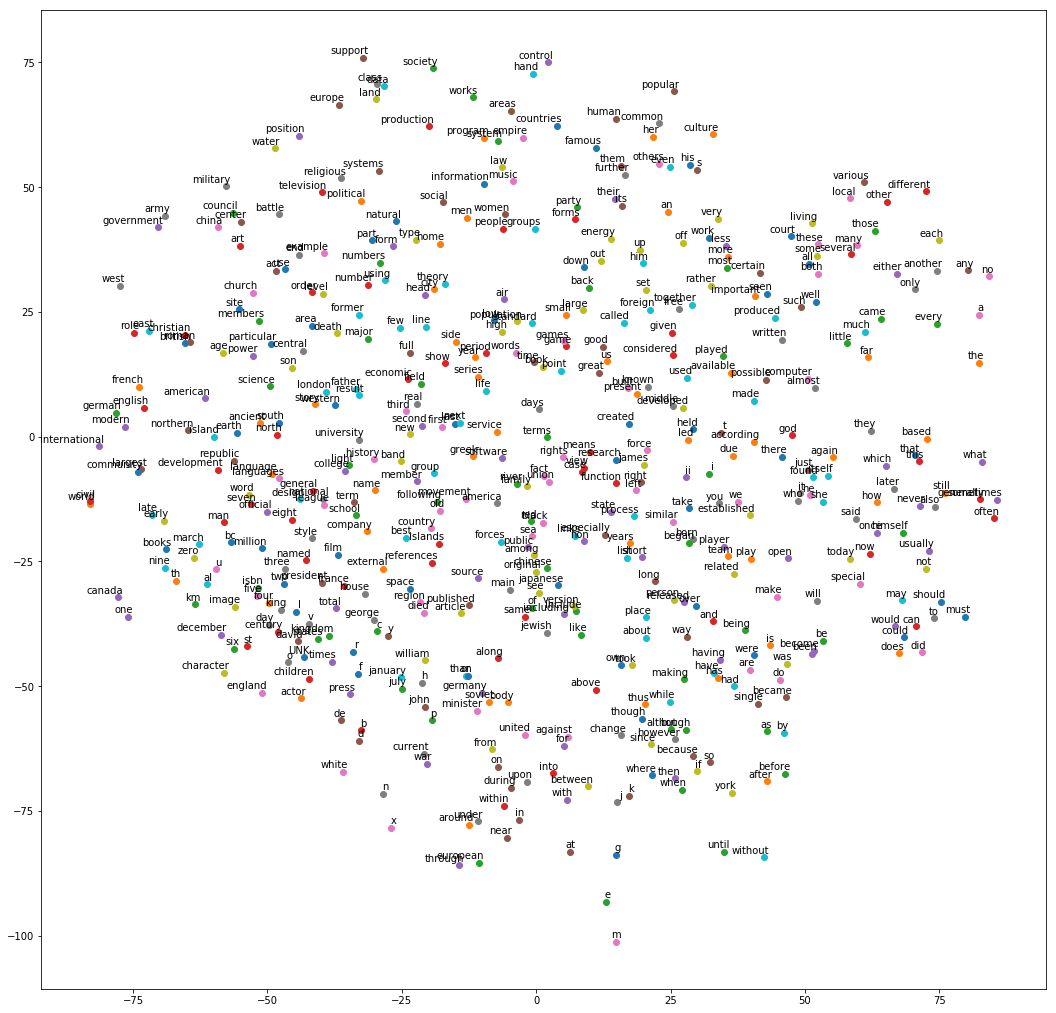

In [21]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)